# ANN, excluding Leu-epitopes

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import torch

2025-01-13 15:54:38.934889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 15:54:38.943040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 15:54:38.951836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 15:54:38.954320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 15:54:38.960931: I tensorflow/core/platform/cpu_feature_guar

In [8]:
def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

torch.cuda.empty_cache()
print_gpu_memory()

import gc

# Invoke garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

Allocated memory: 0.00 MB
Cached memory: 0.00 MB


## dataset

In [2]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_C,has_I,has_L,has_K,has_F,has_P,has_S,has_T,has_Y,has_V
2777221,TTVERLSQT,0,16.888889,0.457778,8.788889,0.148222,3.362222,13.0,0.050,8.6,...,0,0,1,0,0,0,1,1,0,1
2550289,MNIQFTAV,1,45.625000,0.932500,7.600000,0.163125,3.477500,57.5,0.895,7.0,...,0,1,0,0,1,0,0,1,0,1
1702055,ADTSSPEEE,0,-16.666667,0.508889,10.333333,0.107444,2.626667,-31.0,0.470,9.2,...,0,0,0,0,0,1,1,1,0,0
1678439,DDPSRGRLG,0,-10.222222,0.643333,9.677778,0.130111,2.904444,-14.0,0.460,9.2,...,0,0,1,0,0,1,1,0,0,0
2431714,GPLWQALQANAAQAR,1,25.200000,0.762667,8.420000,0.140467,2.982000,41.0,0.610,8.1,...,0,0,1,0,0,1,0,0,0,0


In [3]:
%load_ext autoreload
%autoreload 2

from seq.my_ann import MyAnn

## filter I: without Leu

In [4]:
# keep epitopes without Leu
feature = 'has_L'
print('entire data:', df.shape)
print('epitopes without Leu:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Leu:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==1) & (df['label']==1))]
sub_df = sub_df.drop([feature,], axis=1)
print('filtered data:', sub_df.shape)

entire data: (3458238, 50)
epitopes without Leu: (550617, 50)
epitopes having Leu: (1314625, 50)
filtered data: (2143613, 49)


In [5]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2143613, 47) float16
y: (2143613,) float16
labels: Counter({0.0: 1592996, 1.0: 550617})
train data: (1200423, 47) (1200423,)
validate data: (514467, 47) (514467,)
test data (428723, 47) (428723,)


In [6]:
# train model
c.declare_model()
c.train(epochs=10)

I0000 00:00:1736801703.280895   45964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736801703.281969   45964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736801703.282100   45964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736801703.283587   45964 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,921 (288.75 KB)

 Trainable params: 73,921 (288.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


I0000 00:00:1736801704.719212   46103 service.cc:146] XLA service 0x73d6ac003ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736801704.719228   46103 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-13 15:55:04.741540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-13 15:55:04.831711: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


  170/37514 ━━━━━━━━━━━━━━━━━━━━ 33s 892us/step - accuracy: 0.7477 - auc: 0.7447 - loss: 0.4928 - mse: 0.1653 - precision: 0.5081 - recall: 0.2924

I0000 00:00:1736801706.048183   46103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37514/37514 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - accuracy: 0.8188 - auc: 0.8924 - loss: 0.3370 - mse: 0.1159 - precision: 0.6504 - recall: 0.6381 - val_accuracy: 0.8351 - val_auc: 0.9092 - val_loss: 0.3163 - val_mse: 0.1078 - val_precision: 0.6809 - val_recall: 0.6746
Epoch 2/10
37514/37514 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.8357 - auc: 0.9079 - loss: 0.3172 - mse: 0.1080 - precision: 0.6717 - recall: 0.7022 - val_accuracy: 0.8442 - val_auc: 0.9164 - val_loss: 0.3047 - val_mse: 0.1030 - val_precision: 0.6814 - val_recall: 0.7395
Epoch 3/10
37514/37514 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.8428 - auc: 0.9139 - loss: 0.3096 - mse: 0.1047 - precision: 0.6804 - recall: 0.7351 - val_accuracy: 0.8487 - val_auc: 0.9199 - val_loss: 0.3005 - val_mse: 0.1012 - val_precision: 0.7028 - val_recall: 0.7130
Epoch 4/10
37514/37514 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.8452 - auc: 0.9162 - loss: 0.3062 - mse: 0.1032 - precision: 0.6832 - recall: 0.7408 - val_accuracy: 0.

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.825454,0.899466,0.327749,0.112487,0.660222,0.660549,0.835091,0.909190,0.316335,0.107843,0.680877,0.674574
1,0.837367,0.909576,0.315204,0.107116,0.672327,0.715860,0.844177,0.916365,0.304650,0.102968,0.681424,0.739460
2,0.843106,0.914344,0.308758,0.104355,0.679772,0.736051,0.848721,0.919934,0.300498,0.101213,0.702781,0.712954
3,0.845568,0.916408,0.306031,0.103135,0.684056,0.741255,0.849308,0.920668,0.300473,0.101007,0.682765,0.772772
4,0.846715,0.917289,0.304745,0.102595,0.685505,0.745272,0.849032,0.921343,0.298994,0.100659,0.680980,0.776334
5,0.847704,0.917884,0.303968,0.102226,0.686599,0.749167,0.850953,0.922037,0.296697,0.099670,0.688531,0.767146
6,0.847990,0.918475,0.303196,0.101873,0.687985,0.747186,0.851722,0.922462,0.295886,0.099261,0.697802,0.746319
7,0.848491,0.919002,0.302372,0.101549,0.689078,0.747597,0.852216,0.923007,0.296183,0.099372,0.704358,0.732472
8,0.849225,0.919368,0.301910,0.101311,0.689635,0.751197,0.847539,0.922359,0.301696,0.101650,0.665443,0.818185
9,0.849064,0.919381,0.301902,0.101310,0.689598,0.750165,0.852924,0.923662,0.295295,0.099086,0.699955,0.748739


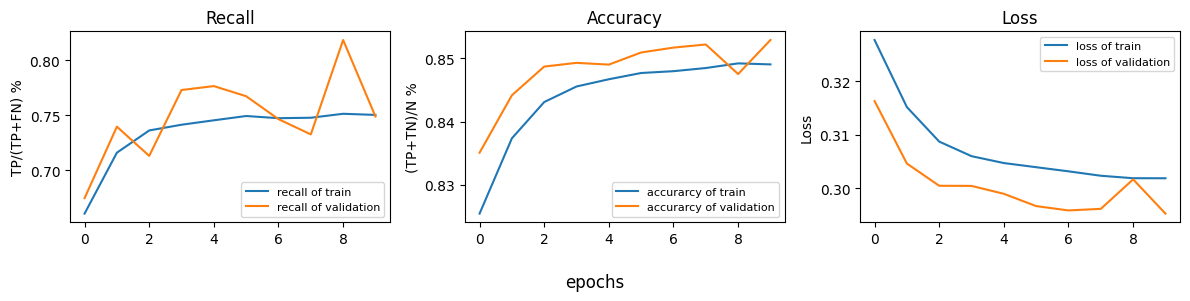

In [7]:
# evaluate model
c.plot_acc_recall()

13398/13398 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.8540 - auc: 0.9236 - loss: 0.2951 - mse: 0.0990 - precision: 0.7014 - recall: 0.7508
{'accuracy': 0.8539056777954102, 'auc': 0.9238765835762024, 'loss': 0.29487600922584534, 'mse': 0.09888618439435959, 'precision': 0.7009115219116211, 'recall': 0.7509274482727051}
13398/13398 ━━━━━━━━━━━━━━━━━━━━ 5s 387us/step
[[0.7611731]
 [0.       ]
 [0.       ]]


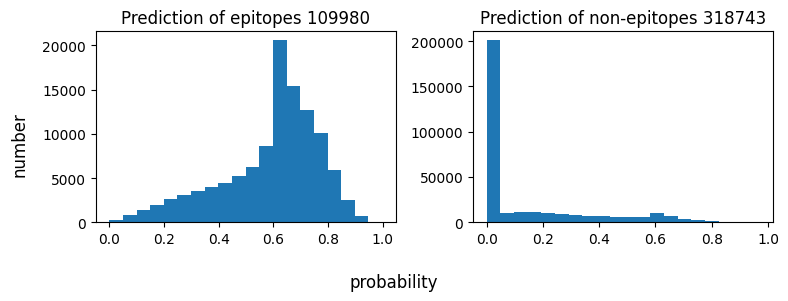

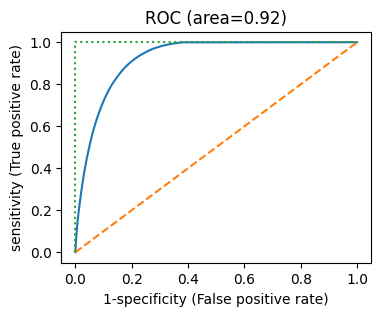

In [8]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [10]:
# save entire model
c.save_model('../models/epitopes_ann_notLeu.keras')

<Sequential name=sequential, built=True>

## filter II: having Leu

In [21]:
# keep epitopes contain Leu
feature = 'has_L'
print('entire data:', df.shape)
print('epitopes without Leu:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Leu:', df[(df[feature]==1) & (df['label']==1)].shape)
sub_df = df[~((df[feature]==0) & (df['label']==1))]
sub_df = sub_df.drop([feature,], axis=1)
print('filtered data:', sub_df.shape)

entire data: (3458238, 50)
epitopes without Leu: (550617, 50)
epitopes having Leu: (1314625, 50)
filtered data: (2907621, 49)


In [22]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2907621, 47) float16
y: (2907621,) float16
labels: Counter({0.0: 1592996, 1.0: 1314625})
train data: (1628267, 47) (1628267,)
validate data: (697829, 47) (697829,)
test data (581525, 47) (581525,)


In [23]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,921 (288.75 KB)

 Trainable params: 73,921 (288.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
50884/50884 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step - accuracy: 0.7305 - auc: 0.8148 - loss: 0.4928 - mse: 0.1705 - precision: 0.6659 - recall: 0.8092 - val_accuracy: 0.7455 - val_auc: 0.8325 - val_loss: 0.4745 - val_mse: 0.1634 - val_precision: 0.6744 - val_recall: 0.8437
Epoch 2/10
50884/50884 ━━━━━━━━━━━━━━━━━━━━ 103s 2ms/step - accuracy: 0.7440 - auc: 0.8294 - loss: 0.4770 - mse: 0.1642 - precision: 0.6761 - recall: 0.8330 - val_accuracy: 0.7497 - val_auc: 0.8365 - val_loss: 0.4687 - val_mse: 0.1609 - val_precision: 0.6811 - val_recall: 0.8379
Epoch 3/10
50884/50884 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.7482 - auc: 0.8335 - loss: 0.4737 - mse: 0.1626 - precision: 0.6820 - recall: 0.8309 - val_accuracy: 0.7510 - val_auc: 0.8389 - val_loss: 0.4682 - val_mse: 0.1606 - val_precision: 0.6764 - val_recall: 0.8602
Epoch 4/10
50884/50884 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step - accuracy: 0.7502 - auc: 0.8358 - loss: 0.4710 - mse: 0.1615 - precision: 0.6841 - recall: 0.8309

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.736893,0.822025,0.484756,0.167379,0.669821,0.824172,0.745475,0.832517,0.474535,0.163373,0.674393,0.843747
1,0.745453,0.830817,0.475892,0.163621,0.678027,0.831880,0.749665,0.836462,0.468653,0.160877,0.681147,0.837870
2,0.748478,0.833952,0.473055,0.162326,0.681860,0.831497,0.751025,0.838924,0.468205,0.160597,0.676387,0.860241
3,0.750335,0.835620,0.471391,0.161591,0.684315,0.831001,0.755529,0.840397,0.464485,0.158961,0.694153,0.819880
4,0.751788,0.836982,0.470041,0.160974,0.686686,0.829200,0.754983,0.842113,0.463960,0.158804,0.684618,0.848138
5,0.752288,0.837859,0.469155,0.160617,0.687846,0.827500,0.757220,0.842687,0.463896,0.158531,0.697805,0.815583
6,0.753158,0.838419,0.468750,0.160376,0.688899,0.827653,0.757100,0.843553,0.462205,0.157847,0.697379,0.816374
7,0.753505,0.838954,0.468210,0.160134,0.689566,0.826936,0.758014,0.843586,0.462988,0.158237,0.703788,0.801462
8,0.753825,0.839309,0.467941,0.160018,0.690426,0.825513,0.757342,0.843846,0.463071,0.158312,0.687416,0.848472
9,0.754335,0.839973,0.467342,0.159724,0.691156,0.825272,0.758022,0.843966,0.463200,0.157933,0.692545,0.834744


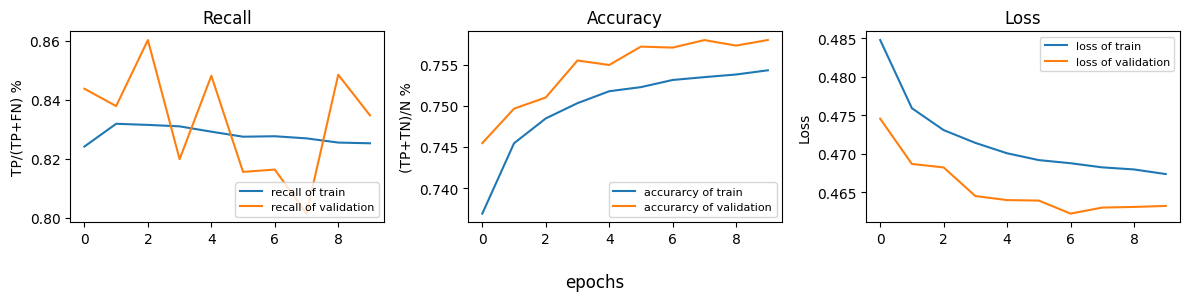

In [24]:
# evaluate model
c.plot_acc_recall()

18173/18173 ━━━━━━━━━━━━━━━━━━━━ 18s 969us/step - accuracy: 0.7593 - auc: 0.8450 - loss: 0.4620 - mse: 0.1574 - precision: 0.6949 - recall: 0.8353
{'accuracy': 0.7586122751235962, 'auc': 0.8446463942527771, 'loss': 0.4624914526939392, 'mse': 0.15755043923854828, 'precision': 0.6942611932754517, 'recall': 0.8350372314453125}
18173/18173 ━━━━━━━━━━━━━━━━━━━━ 9s 482us/step
[[6.7200589e-01]
 [1.0477274e-22]
 [5.0954235e-01]]


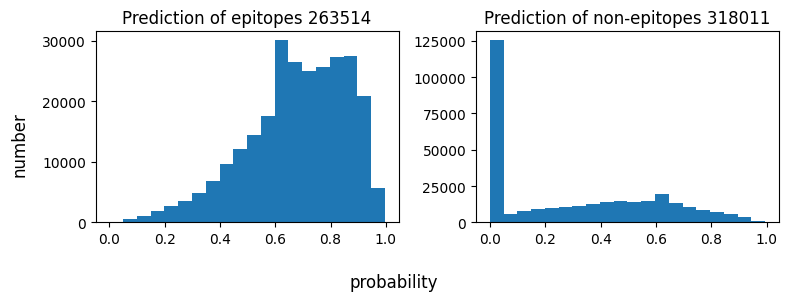

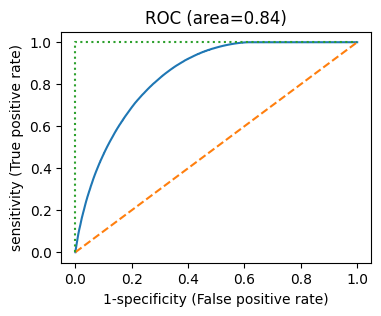

In [25]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [27]:
# save entire model
c.save_model('../models/epitopes_ann_hasLeu.keras')

<Sequential name=sequential_2, built=True>